In [1]:
import json
import os
import re
from glob import glob
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
import subprocess
import fnmatch
import rasterio as rio
import rasterstats as rs
import matplotlib.pyplot as plt
from munging import reproject_raster
import munging as munge
from pprint import pp
from datetime import date
from zipfile import ZipFile
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from shapely.geometry import MultiPolygon, Polygon

In [13]:
# subprocess.run([r'C:/Users/mjn/Documents/Foresite/Sen2Cor-02.09.00-win64/L2A_Process.bat', '--help'], capture_output=True)
# subprocess.run([r'C:/Users/mjn/Documents/Foresite/Sen2Cor-02.09.00-win64/L2A_Process.bat', '--resolution=10'], capture_output=True)

In [39]:
all_files = glob("C:/Users/mjn/Documents/Dev/Foresite/geospatial/data/img_downloads/strips/*.SAFE")
toa_files = [file for file in all_files if 'MSIL1C' in file]
for i in toa_files:
    subprocess.run([r'C:/Users/mjn/Documents/Foresite/Sen2Cor-02.09.00-win64/L2A_Process.bat', f'{i}', '--resolution=10'], capture_output=True)
# toa_files

In [30]:
toa_files

'C:\\Users\\mjn\\Documents\\Dev\\Foresite\\geospatial\\data\\img_downloads\\biocentury\\S2A_MSIL1C_20170706T165851_N0205_R069_T15TVG_20170706T170236.SAFE'

In [42]:
folder_name = 'strips'
# folder_name = 'biocentury'
# folder_name = 'cas'
# field_name = 'accola'
field_name = 'basswood'
# field_name = 'interim'
# field_name = 'orbweavernorth'
# field_name = 'orbweaversouth'
# field_name = 'ebilsland'
# field_name = 'cas'
start_date = '20180701'
end_date = '20180731'
wd = 'C:\\Users\\mjn\\Documents\\Dev\\Foresite\\geospatial'
os.chdir(wd)
# field_boundary_file = 'accola_bounds_4326.geojson'
# field_boundary_file = 'eb_kf_bounds_4326.geojson'
field_boundary_file = 'basswood_bounds_4326.geojson'
# field_boundary_file = 'interim_bounds_4326.geojson'
# field_boundary_file = 'orbweaver_north_bounds_4326.geojson'
# field_boundary_file = 'orbweaver_south_bounds_4326.geojson'
# field_boundary_file = 'cas_bounds.geojson'
footprint = geojson_to_wkt(read_geojson(f'data\\field_boundaries\\{field_boundary_file}'))
img_downloads_path = f'data\\img_downloads\\{folder_name}'
ndvi_out_path = f'data\\ndvi\\{folder_name}\\{field_name}'
gci_out_path = f'data\\gci\\{folder_name}\\{field_name}'
field_bounds = gpd.read_file(f'data\\field_boundaries\\{field_boundary_file}')
field_32615 = field_bounds.to_crs({'init': 'epsg:32615'})

In [43]:
api = SentinelAPI('mnowatzke', 'Lux68bourg19&', 'https://scihub.copernicus.eu/dhus')

In [44]:
products_gdf = munge.find_sentinel_products(footprint, api, start_date, end_date, 15)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted['cloudcoverpercentage']

0c74d70d-e25b-44aa-b31f-f677851a8101     0.0000
bf49becb-0e69-4452-b6e9-53d5d45e6d22     0.0000
7ba36acf-6d9a-44e6-981d-2c8e4d6b73bd     0.0000
5a258e0d-de6a-4b2f-bcf0-cbc2192f4d75     0.0017
f721380b-d468-45bc-96a9-11173757ea78     1.4553
ca1c5c26-b978-4e5c-9271-cced47a1b310     3.5738
b87080dc-fc51-4fde-b562-6dcd84f33ae3     4.4850
929fc742-42f6-4e6f-9e8a-2fdd6a02e30c     5.2994
5abe873f-d77b-4d28-9685-dec43eae6bf8     6.7571
97e152f6-c8c6-4ba0-8f80-e97251047ad2    12.3154
c420fb73-99b2-46ec-bba7-abd254d32423    22.8932
7166ee32-7751-410a-b8de-6a51ad8801a2    42.0480
Name: cloudcoverpercentage, dtype: float64

In [45]:
img_index = 5

In [46]:
img_uuid = products_gdf_sorted.index[img_index]
img_meta = products_gdf_sorted.iloc[img_index]
img_title = img_meta['title']
img_title

'S2A_MSIL1C_20180721T165851_N0206_R069_T15TVF_20180721T221510'

In [48]:
image_download = munge.download_sentinel_image(products_gdf_sorted, api, img_downloads_path, img_index=img_index)

Downloading:  61%|██████▏   | 509M/829M [42:02<26:26, 202kB/s]
MD5 checksumming: 100%|██████████| 509M/509M [00:00<00:00, 559MB/s]


InvalidChecksumError: File corrupt: checksums do not match

In [16]:
large_ndvi_out_path = f"{ndvi_out_path}\\{img_title}_ndvi.tiff"
cropped_out_path = f"{ndvi_out_path}\\{img_title}_{field_name}_ndvi.tiff"
large_ndvi_out_path, cropped_out_path

('data\\ndvi\\cas\\cas\\S2A_MSIL1C_20160718T165322_N0204_R026_T15TWH_20160718T165826_ndvi.tiff',
 'data\\ndvi\\cas\\cas\\S2A_MSIL1C_20160718T165322_N0204_R026_T15TWH_20160718T165826_cas_ndvi.tiff')

In [17]:
#munge.check_product_status(img_uuid, api)

In [18]:
os.chdir(wd)

In [4]:
munge.unzip_sentinel_images(img_downloads_path, img_title)

In [12]:
img_path = f"{img_downloads_path}\\{img_title}.SAFE\\GRANULE\\"
#img_path = "data/S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE/GRANULE/L1C_T15TVG_A016125_20180724T171717/IMG_DATA"

In [13]:
img_path

'data\\img_downloads\\cas\\S2B_MSIL1C_20190601T165859_N0207_R069_T15TWH_20190601T203146.SAFE\\GRANULE\\'

In [14]:
file_list = munge.get_image_bands(img_path)
if len(file_list) == 0:
    print('No images found.')
else:
    pp(file_list)

['data\\img_downloads\\cas\\S2B_MSIL1C_20190601T165859_N0207_R069_T15TWH_20190601T203146.SAFE\\GRANULE\\L1C_T15TWH_A011678_20190601T171124\\IMG_DATA\\T15TWH_20190601T165859_B04.jp2',
 'data\\img_downloads\\cas\\S2B_MSIL1C_20190601T165859_N0207_R069_T15TWH_20190601T203146.SAFE\\GRANULE\\L1C_T15TWH_A011678_20190601T171124\\IMG_DATA\\T15TWH_20190601T165859_B08.jp2']


In [15]:
munge.create_ndvi_tif(file_list, large_ndvi_out_path)

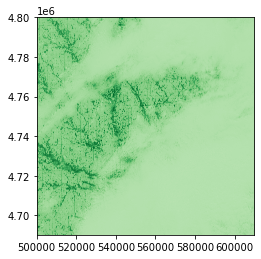

In [16]:
ndvi_all = rio.open(large_ndvi_out_path)
show((ndvi_all, 1), cmap="Greens")

In [17]:
munge.clip_raster(large_ndvi_out_path, field_32615.geometry, cropped_out_path)

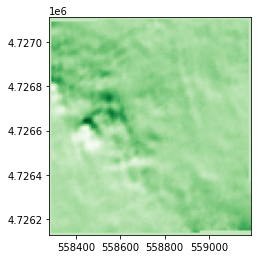

In [18]:
ndvi_clipped = rio.open(cropped_out_path)
show((ndvi_clipped, 1), cmap="Greens")

In [2]:
accola_2018 = rio.open('data\\img_downloads\\biocentury\\S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE\\GRANULE\\L1C_T15TVG_A016125_20180724T171717\IMG_DATA\T15TVG_20180724T170851_TCI.jp2')
meta = accola_2018.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

In [3]:
rbg_images = munge.get_image_bands('data\\img_downloads\\biocentury\\S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE\\GRANULE', img_bands=['*B04.jp2','*B04_10m.jp2', '*B02.jp2','*B02_10m.jp2','*B03.jp2','*B03_10m.jp2'])

In [4]:
rbg_images

['data\\img_downloads\\biocentury\\S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE\\GRANULE\\L1C_T15TVG_A016125_20180724T171717\\IMG_DATA\\T15TVG_20180724T170851_B02.jp2',
 'data\\img_downloads\\biocentury\\S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE\\GRANULE\\L1C_T15TVG_A016125_20180724T171717\\IMG_DATA\\T15TVG_20180724T170851_B03.jp2',
 'data\\img_downloads\\biocentury\\S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE\\GRANULE\\L1C_T15TVG_A016125_20180724T171717\\IMG_DATA\\T15TVG_20180724T170851_B04.jp2']

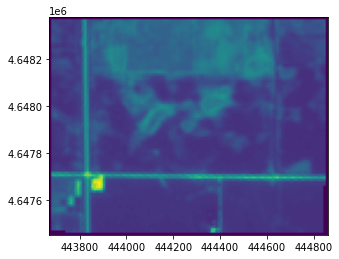

<AxesSubplot:>

In [22]:
# munge.create_rgb_tif(rbg_images, 'data/biocentury/accola/images/rgb/accola_20180724_rgb.tif')
# munge.clip_raster('data/biocentury/accola/images/rgb/accola_20180724_rgb.tif', field_32615.geometry, 'data/biocentury/accola/images/rgb/accola_20180724_rgb_clipped.tif')
accola_rgb = rio.open('data/biocentury/accola/images/rgb/accola_20180724_rgb_clipped.tif')
show((accola_rgb, 3))

In [22]:
tci_image = munge.get_TCI_image('data\\img_downloads\\biocentury\\S2A_MSIL1C_20190726T165901_N0208_R069_T15TVG_20190726T204236.SAFE\\GRANULE')

In [ ]:
tci_image

In [2]:
folder_name = 'biocentury'
# field_name = 'ebilsland'
field_name = 'accola'
start_date = '20180701'
end_date = '20180731'
wd = 'C:\\Users\\mjn\\Documents\\Dev\\Foresite\\geospatial'
os.chdir(wd)
field_boundary_file = 'accola_bounds_4326.geojson'
# field_boundary_file = 'eb_kf_bounds_4326.geojson'
footprint = geojson_to_wkt(read_geojson(f'data\\field_boundaries\\{field_boundary_file}'))
# img_downloads_path = f'data\\img_downloads\\{folder_name}'
# ndvi_out_path = f'data\\ndvi\\{folder_name}\\{field_name}'
# gci_out_path = f'data\\gci\\{folder_name}\\{field_name}'
savi_out_path = f'data\\savi\\{folder_name}\\{field_name}'
field_bounds = gpd.read_file(f'data\\field_boundaries\\{field_boundary_file}')
field_32615 = field_bounds.to_crs({'init': 'epsg:32615'})

C:\Users\mjn\miniconda3\envs\gis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
gci_paths = munge.get_image_bands('data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE', img_bands=['*B03.jp2', '*B08.jp2'])

In [9]:
munge.create_gci_tif(gci_paths, 'data/biocentury/accola/images/gci/accola_20190729_gci_full.tif')

In [10]:
munge.clip_raster('data/biocentury/accola/images/gci/accola_20190729_gci_full.tif', field_32615.geometry, 'data/biocentury/accola/images/gci/accola_20190729_gci_clipped.tif')

In [4]:
savi_paths = munge.get_image_bands('data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE', img_bands=['*B04.jp2', '*B08.jp2'])

In [5]:
munge.create_savi_tif(savi_paths, 'data/biocentury/ebilsland/images/savi/ebilsland_20190729_savi_full.tif')

In [6]:
munge.clip_raster('data/biocentury/ebilsland/images/savi/ebilsland_20190729_savi_full.tif', field_32615.geometry, 'data/biocentury/ebilsland/images/savi/ebilsland_20190729_savi_clipped.tif')

In [3]:
evi_paths = munge.get_image_bands('data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE', img_bands=['*B02.jp2', '*B04.jp2', '*B08.jp2'])

In [4]:
evi_paths

['data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE\\L1C_T15TVG_A021416_20190729T172152\\IMG_DATA\\T15TVG_20190729T170901_B02.jp2',
 'data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE\\L1C_T15TVG_A021416_20190729T172152\\IMG_DATA\\T15TVG_20190729T170901_B04.jp2',
 'data\\img_downloads\\biocentury\\S2A_MSIL1C_20190729T170901_N0208_R112_T15TVG_20190729T220805.SAFE\\GRANULE\\L1C_T15TVG_A021416_20190729T172152\\IMG_DATA\\T15TVG_20190729T170901_B08.jp2']

In [5]:
munge.create_evi_tif(evi_paths, 'data/biocentury/accola/images/evi/accola_20190729_evi_full.tif')

In [6]:
munge.clip_raster('data/biocentury/accola/images/evi/accola_20190729_evi_full.tif', field_32615.geometry, 'data/biocentury/accola/images/evi/accola_20190729_evi_clipped.tif')

In [ ]:
evi_accola = rio.open()
show((evi_accola, 1), cmap="Greens")